# Final Project

### Initial setup

In [1]:
import numpy as np 
import tensorflow as tf
from tensorflow import keras, image
from keras import layers, models, Input, regularizers
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Reshape, Resizing, GlobalAveragePooling2D, GlobalMaxPooling2D, Normalization
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet101
from keras.applications.resnet_v2 import ResNet50V2
#from keras.applications.resnet50 import ResNet50
import sys
import tracemalloc

### Data augmentation and preprocessing

In [2]:
num_classes = 10
batch_size = 4

#Fixing randomness
tf.random.set_seed(0)

# Shape of image samples

# loading data and labels np arrays

data_train = np.load('data_train.npy').T
labels_train = np.load('labels_train.npy')
labels_train = labels_train.astype(int)

### Correcting labels

corrected_labels_train = labels_train.copy()
changes = {
    0: [2400, 361, 2439, 1865, 2671, 893, 3625],
    1: [1288, 3033, 3037, 3599, 780, 3140, 3372],
    2: [1670, 673, 1995, 2804, 2769, 2714, 653],
    3: [2980, 2937, 603, 1819, 3704, 2025],
    4: [2665, 1649, 1777, 1563, 2986],
    5: [1587, 2750, 2763, 1917],
    6: [2015, 2388, 38, 401, 2818, 1875, 3675],
    7: [3154, 744, 452, 3283, 3412, 313],
    8: [556, 1213, 3253],
    9: [2940, 1314, 1108, 708, 3277, 728],
}
for new_label, indices_to_change in changes.items():
    for index in indices_to_change:
        corrected_labels_train[index] = new_label

labels_train = corrected_labels_train

#Train-test split
#data_train, data_test, labels_train, labels_test = train_test_split(data_train,
#                                                        labels_train,
#                                                        test_size=0.2,
#                                                        shuffle=True,
#                                                        random_state=0)

## Data augmentation

# Reshape and resize images
num_images = data_train.shape[0]
num_channels = 3
data_reshaped = np.zeros((num_images, 300, 300, 3), dtype=np.float32)

for i in range(num_images):
    image = data_train[i,:].reshape((300,300,3))
    image_processed = image/255.0
    data_reshaped[i] = image_processed
    
del data_train

#train-val split

data_reshaped, data_val, labels_train, labels_val = train_test_split(data_reshaped,
                                                        labels_train,
                                                        test_size=0.1,
                                                        shuffle=True,
                                                        random_state=0)

# data generator - generates augemented data in training
datagen = ImageDataGenerator(
    rotation_range = 20,  # reduced the range
    width_shift_range = 0.2,  # reduced the range
    height_shift_range = 0.2,  # reduced the range
    shear_range=0.1,  # reduced the range
    zoom_range=0.1,  # reduced the range
    horizontal_flip = True,
    vertical_flip = True,  # added vertical flip
    fill_mode='nearest',
    #preprocessing_function=tf.keras.applications.resnet50.preprocess_input # applying necessary resnet preprocessing
)


train_data_gen = datagen.flow(
    data_reshaped,
    labels_train,
    batch_size=batch_size,
    shuffle=True,
)

val_data_gen = datagen.flow(
    data_val,
    labels_val,
    batch_size=batch_size,
    shuffle=False
)

### Creating the CNN model

In [3]:
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-50]:
    layer.trainable = False

model = models.Sequential([
    Normalization(mean=[0.485, 0.456, 0.406], variance=[0.229, 0.224, 0.225], input_shape=(300, 300, 3)),
    Resizing(224, 224),
    base_model,
    Dropout(0.5),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.25),
    BatchNormalization(),
    Dense(10, activation='softmax')
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

2023-04-25 16:46:40.594539: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 16:46:41.166958: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79111 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0


### Training the model

In [4]:
#batch size - # of samples model uses to minimize loss function
batch_size = 32

#epochs - # of times model sees the entire dataset
epochs = 50

checkpoint_cb = keras.callbacks.ModelCheckpoint('best_model.h5', 
                                                save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  monitor='val_loss',
                                                  restore_best_weights=True)


#fit the model to the training data. Use 20% of data as validation data
history = model.fit(data_reshaped, labels_train, batch_size=batch_size, epochs=epochs, validation_data = (data_val, labels_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50


2023-04-25 16:46:48.679213: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2023-04-25 16:46:49.798795: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2023-04-25 16:46:50.012350: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-04-25 16:46:51.161937: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


105/105 [==============================] - ETA: 0s - loss: 0.6436 - accuracy: 0.8117

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


105/105 [==============================] - 11s 48ms/step - loss: 0.6436 - accuracy: 0.8117 - val_loss: 15.5493 - val_accuracy: 0.4194
Epoch 2/50
105/105 [==============================] - 4s 35ms/step - loss: 0.3081 - accuracy: 0.9136 - val_loss: 0.7921 - val_accuracy: 0.8414
Epoch 3/50
105/105 [==============================] - 3s 30ms/step - loss: 0.2394 - accuracy: 0.9303 - val_loss: 2.7112 - val_accuracy: 0.8065
Epoch 4/50
105/105 [==============================] - 4s 35ms/step - loss: 0.1528 - accuracy: 0.9561 - val_loss: 0.2285 - val_accuracy: 0.9328
Epoch 5/50
105/105 [==============================] - 4s 35ms/step - loss: 0.1072 - accuracy: 0.9677 - val_loss: 0.2225 - val_accuracy: 0.9355
Epoch 6/50
105/105 [==============================] - 4s 35ms/step - loss: 0.0768 - accuracy: 0.9776 - val_loss: 0.2020 - val_accuracy: 0.9597
Epoch 7/50
105/105 [==============================] - 3s 29ms/step - loss: 0.0634 - accuracy: 0.9830 - val_loss: 0.2947 - val_accuracy: 0.9301
Epoch 8/

### Evaluating model

In [15]:
#reshaping validation data
# Reshape and resize images
num_images = data_val.shape[0]
num_channels = 3
data_test_resized = np.zeros((num_images, 300, 300, 3), dtype=np.float32)


### Will need for test script
#for i in range(num_images):
    # Reshape image
    #image = data_val[i,:].reshape((300,300,3))
    # Resize image
    #image_resized = tf.image.resize(image, size=(224, 224)).numpy()
    # Normalize image
    #image_normalized = image/255
    # Save resized and normalized image to data_resized array
    #data_test_resized[i] = image_normalized

model = keras.models.load_model("best_model.h5")
score = model.evaluate(data_val, labels_val, verbose=0)
print("loss:", score[0])
print("accuracy:", score[1])

loss: 0.1520656794309616
accuracy: 0.9623655676841736


Predicted label: Honda, True label: Honda
Probabilities: [1.4606712e-07 1.2664844e-08 7.4815995e-07 9.9999905e-01 2.6190925e-09
 3.4412636e-08 7.8744414e-08 1.0352188e-09 2.4737325e-08 1.3457576e-09]


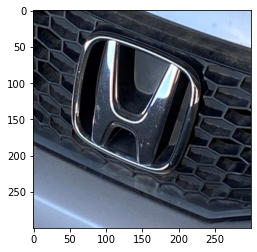

['Adidas', 'General Mills', '3M', '3M', "McDonald's", '3M', '3M', 'Honda', '3M', 'Unilever', 'Adidas', 'Honda', 'Nike', 'Gators', 'Gators', 'Gators', 'Ford', "McDonald's", 'Unilever', 'KFC', 'Unilever', 'Adidas', 'Gators', 'General Mills', 'Gators', '3M', 'Ford', '3M', "McDonald's", 'Unilever', 'Adidas', 'KFC', 'Nike', 'KFC', 'Nike', 'Unilever', 'Ford', 'Gators', 'Ford', 'KFC', "McDonald's", 'KFC', 'Ford', 'Adidas', 'Unilever', 'Nike', 'Honda', 'Unilever', 'Ford', 'Ford', 'Honda', 'KFC', 'Nike', 'KFC', 'Honda', 'Nike', 'Gators', 'Honda', 'Gators', 'KFC', 'Ford', 'Nike', 'Ford', "McDonald's", 'Ford', 'Unilever', "McDonald's", '3M', 'KFC', "McDonald's", 'KFC', "McDonald's", 'KFC', 'Ford', 'Nike', 'Honda', 'Nike', "McDonald's", 'General Mills', 'Unilever', 'KFC', 'KFC', 'Adidas', 'General Mills', '3M', "McDonald's", 'Nike', 'Unilever', 'Nike', 'General Mills', 'Nike', 'Adidas', 'KFC', 'Nike', 'Adidas', 'Honda', 'KFC', 'Honda', '3M', "McDonald's", 'Nike', '3M', '3M', "McDonald's", 'KFC', '

In [22]:
import matplotlib.pyplot as plt

class_names = ['Nike',
                'Adidas',
                'Ford',
                'Honda',
                'General Mills',
                'Unilever',
                "McDonald's",
                'KFC',
                'Gators',
                '3M']

labels_val = labels_val.astype(int)


def predict_and_show(index):
    probs = model.predict(data_val)[index]
    predicted_label = class_names[np.argmax(probs)]
    true_label = class_names[labels_val[index]]
    print(f"Predicted label: {predicted_label}, True label: {true_label}")
    print(f"Probabilities: {probs}")
    plt.imshow(data_val[index])
    plt.show()

predict_and_show(int(7))

import numpy as np

# Get predictions as probabilities
probs = model.predict(data_val)

# Get predicted class for each input
pred_classes = np.argmax(probs, axis=-1)

# Convert predicted class indices to class names
pred_class_names = [class_names[i] for i in pred_classes]
print(pred_class_names)


In [11]:
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-10]:
    layer.trainable = False

model = models.Sequential([
    Normalization(mean=[0.485, 0.456, 0.406], variance=[0.229, 0.224, 0.225], input_shape=(300, 300, 3)),
    Resizing(224, 224),
    base_model,
    Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    GlobalAveragePooling2D(),
    Dense(2048, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])


In [8]:
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-50]:
    layer.trainable = False

model = models.Sequential([
    Normalization(mean=[0.485, 0.456, 0.406], variance=[0.229, 0.224, 0.225], input_shape=(300, 300, 3)),
    Resizing(224, 224),
    base_model,
    Dropout(0.5),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(10, activation='softmax')
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])